In [156]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.python.data.ops.dataset_ops import PrefetchDataset

### 1. Найти данные для классификации. Данные в группе повторяться не должны! Предобработать данные, если это необходимо.

In [157]:
dataset, metadata = tfds.load('eurosat', as_supervised=True, with_info=True)
# dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
dataset: PrefetchDataset = dataset['train']
dataset = dataset.take(5000) # svm работает оч неторопливо (время квадратично от размера)

In [158]:
import tensorflow as tf
def convert_img_to_grayscale(image) -> list:
    return tfds.as_numpy(tf.image.rgb_to_grayscale(image)).ravel().tolist()

class_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
# class_names = [
#     'Футболка / топ', "Шорты", "Свитер", "Платье",
#     "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
#     "Ботинок"]
# data_reshaped = pd.DataFrame([convert_img_to_grayscale(image) for image, label in dataset])
# target_names = pd.Series([class_names[label] for image, label in tfds.as_numpy(dataset)])

In [159]:
data_reshaped = pd.DataFrame([image.ravel().tolist() for image, label in tfds.as_numpy(dataset)])
target_names = pd.Series([class_names[label] for image, label in tfds.as_numpy(dataset)])

In [160]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
data_reshaped = pd.DataFrame(scaler.fit_transform(data_reshaped), columns=data_reshaped.columns)
data_reshaped.head()

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0.067797,0.096774,0.084577,0.067797,0.096774,0.075377,0.072034,0.105505,0.085,0.084746,...,0.103960,0.072034,0.127854,0.104478,0.063830,0.128440,0.090,0.046610,0.105505,0.065
1,0.423729,0.391705,0.348259,0.444915,0.396313,0.351759,0.533898,0.454128,0.430,0.550847,...,0.277228,0.313559,0.305936,0.248756,0.285106,0.302752,0.240,0.262712,0.293578,0.235
2,0.368644,0.294931,0.223881,0.360169,0.299539,0.216080,0.330508,0.284404,0.205,0.322034,...,0.247525,0.334746,0.296804,0.199005,0.353191,0.298165,0.225,0.364407,0.307339,0.235
3,0.406780,0.313364,0.283582,0.398305,0.317972,0.266332,0.470339,0.426606,0.375,0.512712,...,0.222772,0.427966,0.415525,0.393035,0.438298,0.444954,0.415,0.211864,0.211009,0.155
4,0.055085,0.082949,0.069652,0.050847,0.073733,0.060302,0.033898,0.050459,0.050,0.033898,...,0.099010,0.059322,0.109589,0.084577,0.051064,0.100917,0.075,0.055085,0.100917,0.075


### 2. Изобразить гистограмму, которая показывает баланс классов. Сделать выводы.

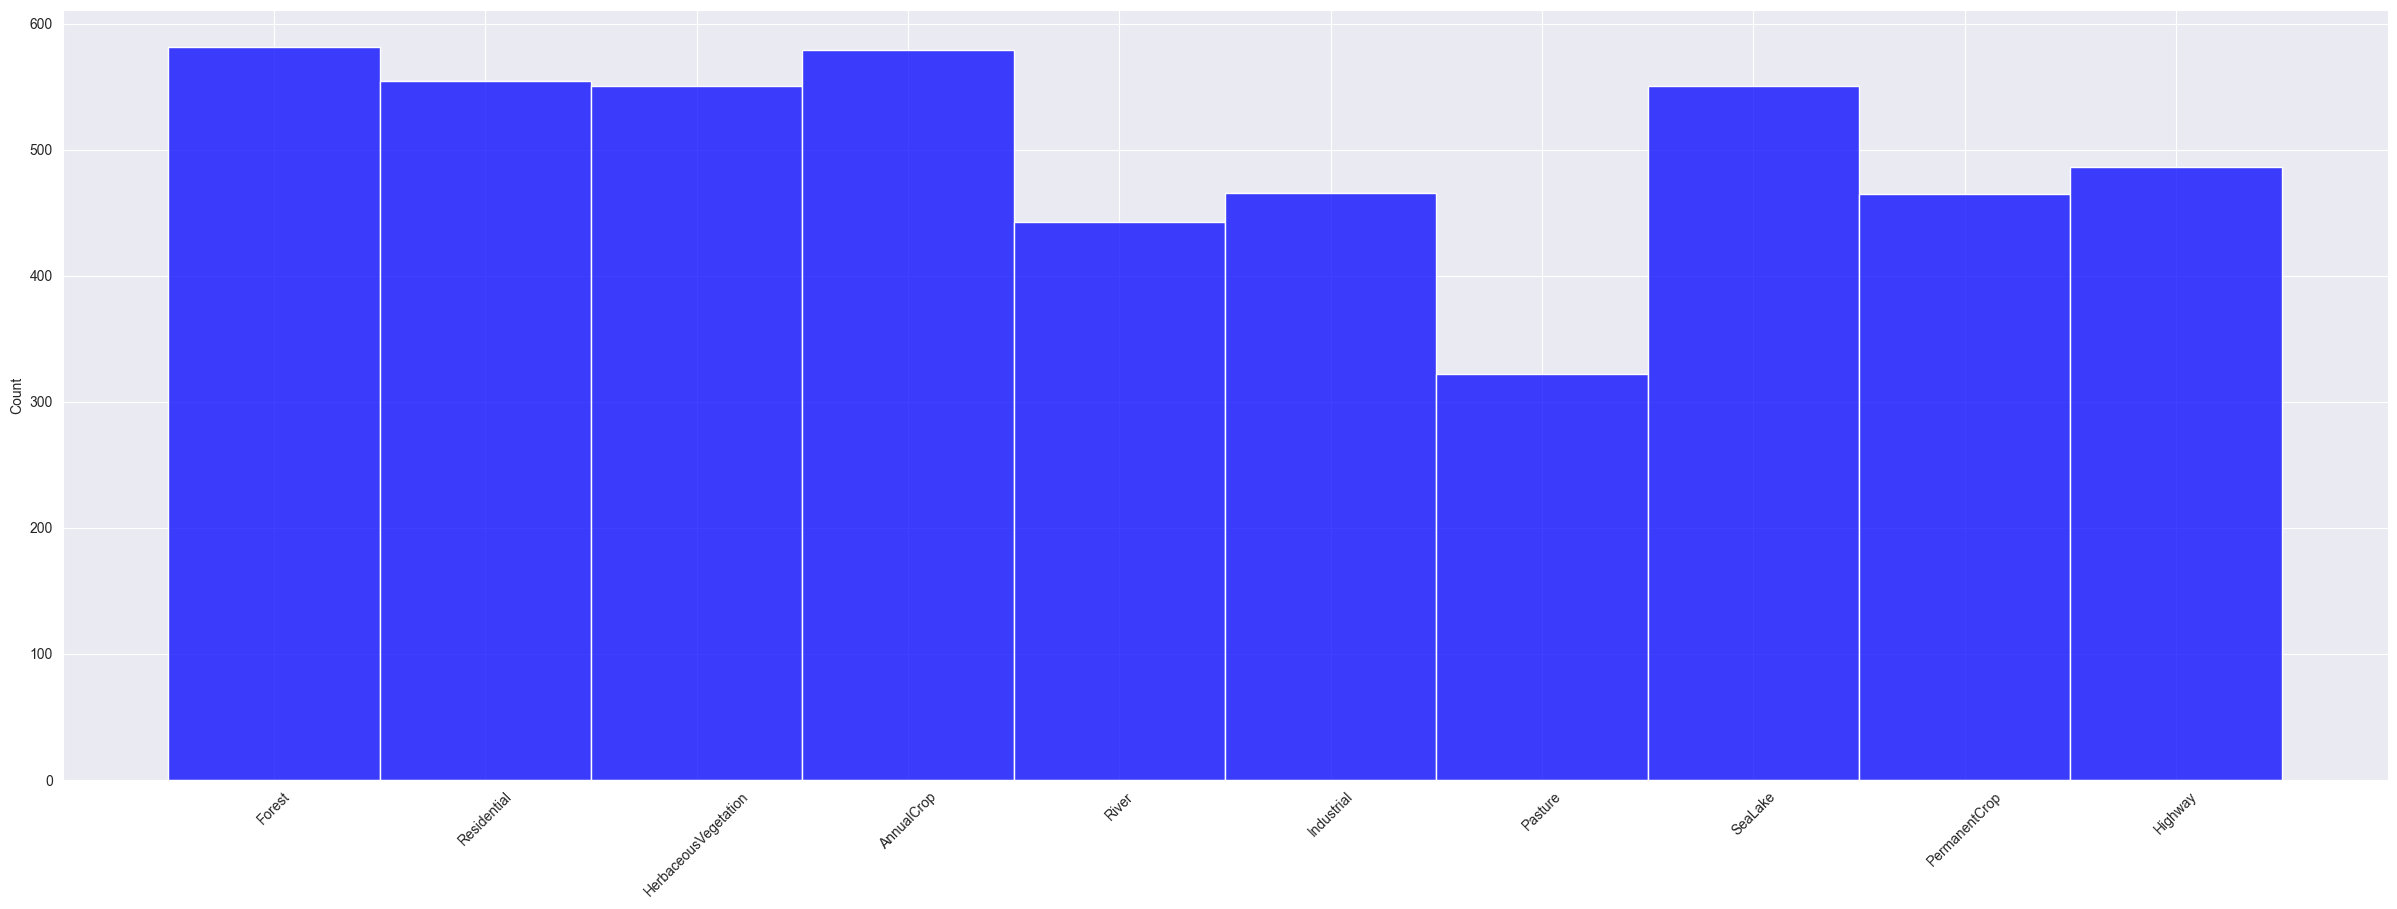

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.xticks(rotation=45)
sns.histplot(target_names, color='b');

### 3. Разбить выборку на тренировочную и тестовую. Тренировочная для обучения модели, тестовая для проверки ее качества.

In [162]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_reshaped, target_names, train_size=0.8, shuffle=True, random_state=271)

In [163]:
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

### 4. Применить алгоритмы классификации: логистическая регрессия, SVM, KNN.
### Построить матрицу ошибок по результатам работы моделей (использовать confusion_matrix из sklearn.metrics).

#### Логистическая регрессия

In [164]:
regression_model = LogisticRegression(max_iter=100, random_state=271, n_jobs=-1)
regression_time = datetime.now()
regression_model.fit(x_train, y_train)
regression_time = datetime.now() - regression_time

regression_predict = regression_model.predict(x_test)

#### SVM (метод опорных векторов)

In [165]:
svc_model = LinearSVC(max_iter=100, random_state=271)
svc_time = datetime.now()
svc_model.fit(x_train, y_train)
svc_time = datetime.now() - svc_time

svc_predict = svc_model.predict(x_test)

C:\Users\dima2\venvs\venv_bd\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### KNN - k Nearest Neighbor

In [166]:
knn_model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_time = datetime.now()
knn_model.fit(x_train, y_train)
knn_time = datetime.now() - knn_time

knn_predict = knn_model.predict(x_test)

In [167]:
from sklearn.metrics import confusion_matrix
def show_conf_matrix(test, predict, ax_, cbar=False):
    sns.heatmap(confusion_matrix(test, predict), annot=True, fmt='', ax=ax_, cbar=cbar)

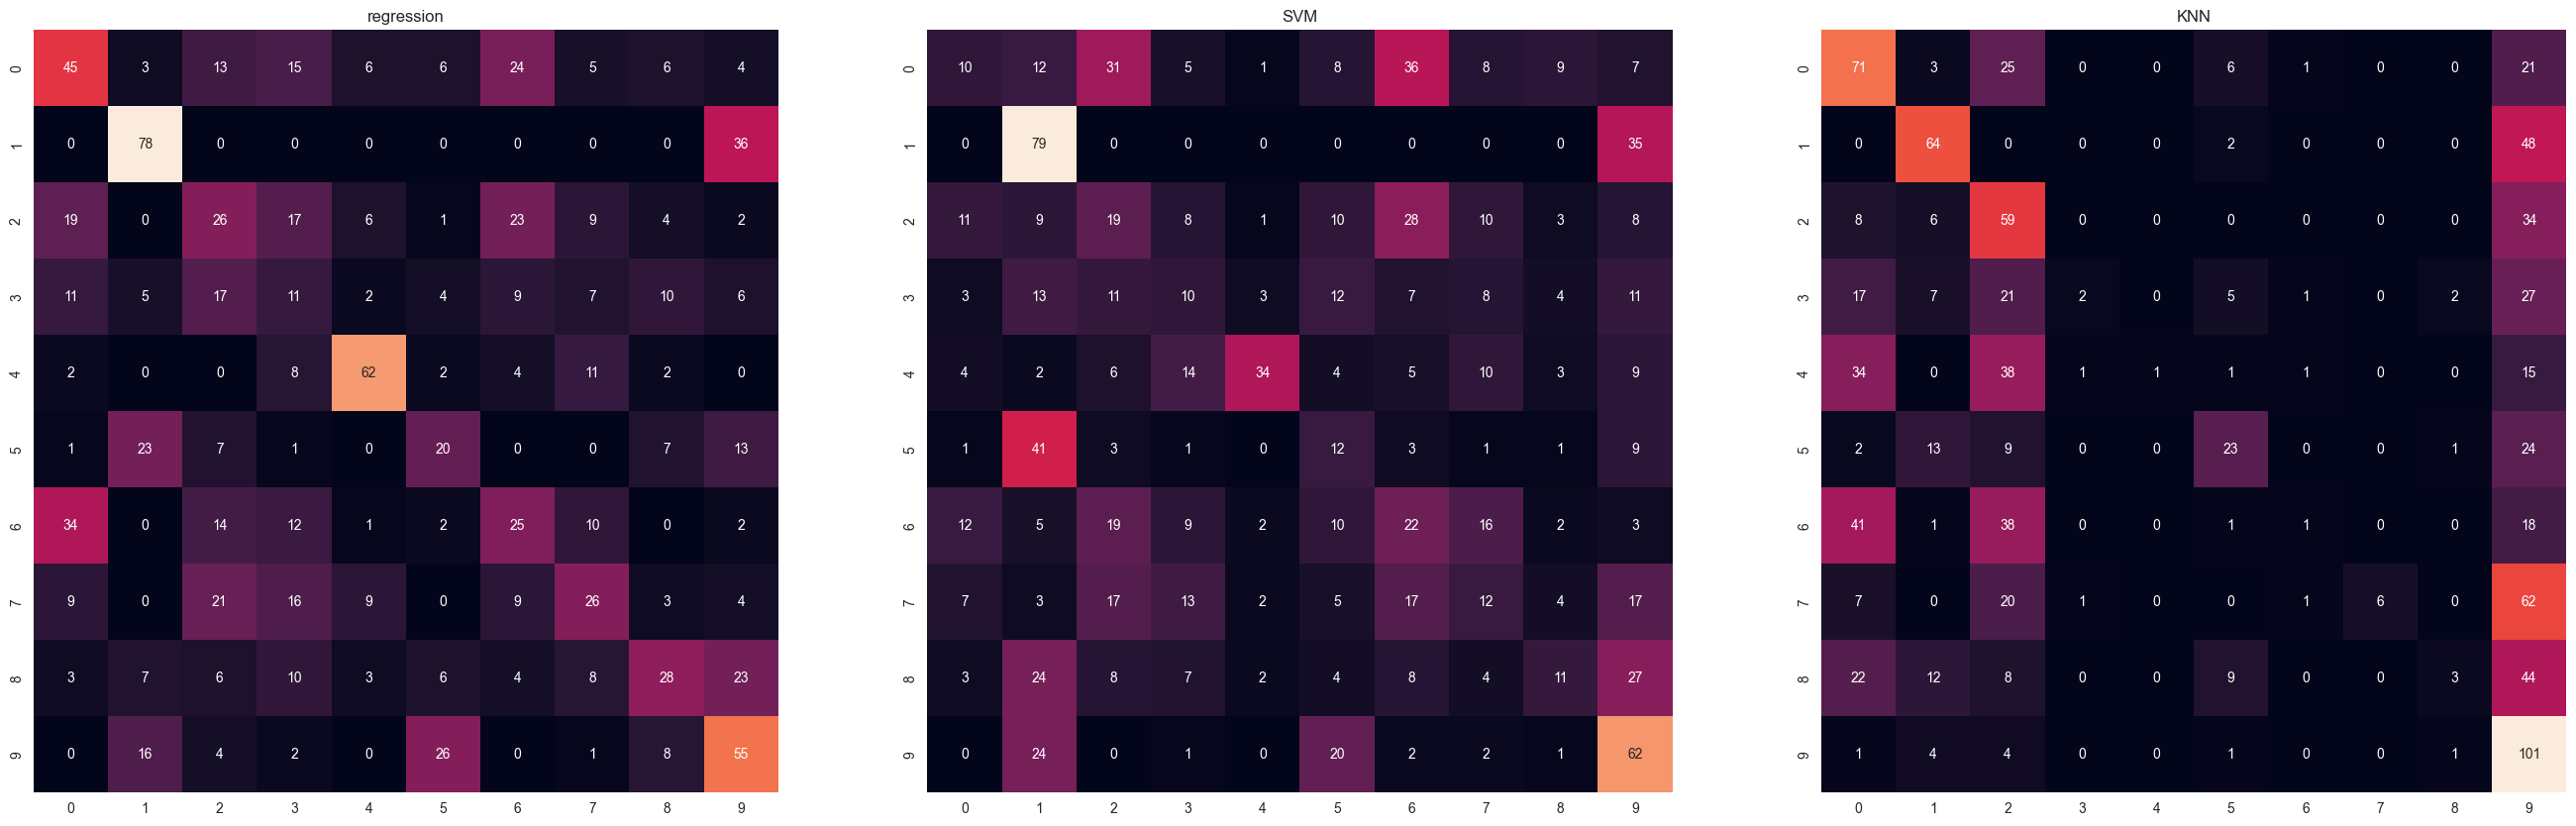

In [168]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(33, 10))
ax1.set_title('regression')
ax2.set_title('SVM')
ax3.set_title('KNN')
show_conf_matrix(y_test, regression_predict, ax1)
show_conf_matrix(y_test, svc_predict, ax2)
show_conf_matrix(y_test, knn_predict, ax3)

### 5. Сравнить результаты классификации, используя accuracy, precision, recall и f1-меру
### (можно использовать classification_report из sklearn.metrics).
### Также сравнить время работы алгоритмов. Сделать выводы.

In [169]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report
def show_stats(model_name: str, model_predict, model_time):
    print(f'Модель {model_name}:')
    print('время обучения модели:', model_time)
    print('accuracy_score:', accuracy_score(y_test, model_predict))
    print('precision_score:', precision_score(y_test, model_predict, average='weighted'))
    print('recall_score:', recall_score(y_test, model_predict, average='weighted'))
    print('f1_score:', f1_score(y_test, model_predict, average='weighted'))
    print()

In [170]:
show_stats('regression', regression_predict, regression_time)
show_stats('SVM', svc_predict, svc_time)
show_stats('KNN', knn_predict, knn_time)

Модель regression:
время обучения модели: 0:00:11.799996
accuracy_score: 0.376
precision_score: 0.37500089949884075
recall_score: 0.376
f1_score: 0.372724745895292

Модель SVM:
время обучения модели: 0:00:59.691562
accuracy_score: 0.271
precision_score: 0.2750819686230197
recall_score: 0.271
f1_score: 0.25066075244999525

Модель KNN:
время обучения модели: 0:00:00.387962
accuracy_score: 0.331
precision_score: 0.4933935887745095
recall_score: 0.331
f1_score: 0.25507765127446913



In [171]:
print(classification_report(y_test, regression_predict))

                      precision    recall  f1-score   support

          AnnualCrop       0.36      0.35      0.36       127
              Forest       0.59      0.68      0.63       114
HerbaceousVegetation       0.24      0.24      0.24       107
             Highway       0.12      0.13      0.13        82
          Industrial       0.70      0.68      0.69        91
             Pasture       0.30      0.28      0.29        72
       PermanentCrop       0.26      0.25      0.25       100
         Residential       0.34      0.27      0.30        97
               River       0.41      0.29      0.34        98
             SeaLake       0.38      0.49      0.43       112

            accuracy                           0.38      1000
           macro avg       0.37      0.37      0.37      1000
        weighted avg       0.38      0.38      0.37      1000



In [172]:
print(classification_report(y_test, svc_predict))

                      precision    recall  f1-score   support

          AnnualCrop       0.20      0.08      0.11       127
              Forest       0.37      0.69      0.48       114
HerbaceousVegetation       0.17      0.18      0.17       107
             Highway       0.15      0.12      0.13        82
          Industrial       0.76      0.37      0.50        91
             Pasture       0.14      0.17      0.15        72
       PermanentCrop       0.17      0.22      0.19       100
         Residential       0.17      0.12      0.14        97
               River       0.29      0.11      0.16        98
             SeaLake       0.33      0.55      0.41       112

            accuracy                           0.27      1000
           macro avg       0.27      0.26      0.25      1000
        weighted avg       0.28      0.27      0.25      1000



In [173]:
print(classification_report(y_test, knn_predict))

                      precision    recall  f1-score   support

          AnnualCrop       0.35      0.56      0.43       127
              Forest       0.58      0.56      0.57       114
HerbaceousVegetation       0.27      0.55      0.36       107
             Highway       0.50      0.02      0.05        82
          Industrial       1.00      0.01      0.02        91
             Pasture       0.48      0.32      0.38        72
       PermanentCrop       0.20      0.01      0.02       100
         Residential       1.00      0.06      0.12        97
               River       0.43      0.03      0.06        98
             SeaLake       0.26      0.90      0.40       112

            accuracy                           0.33      1000
           macro avg       0.51      0.30      0.24      1000
        weighted avg       0.49      0.33      0.26      1000

